## Aprendizaje Profundo
# **Image captioning en Python**

---


## Máster en Inteligencia Computacional e IoT (Universidad de Córdoba)
## Instituto de Estudios de Posgrado
### 7 de marzo de 2022
### **José Manuel Alcalde Llergo**
### 31023054-X
### i72alllj@uco.es

## Introducción

El problema de *image captioning* consiste en generar a partir de una fotografía una descripción (*caption* o pie de foto) de la misma de manera automática. A lo largo de la parte teórica de este trabajo hemos analizado el paper [1] en el que hemos visto una metodología para resolver este problema empleando un estructura *Encoder*-*Decoder* donde el codificador de las características de la imagen ha sido una CNN y el decodificador un LSTM que emplea a su vez mecanismos de antención para centrarse en las zonas más relevantes de la imagen a la hora de generar cada una de las palabras de la descripción final.

Durante este tutorial vamos a tratar de abordar el mismo problema sobre uno de los conjuntos de datos que también se han empleado en la experimentación de [1], Flickr8k [2]. Este conjunto de datos esta compuesto por 8.000 imágenes acompañadas por 5 descripciones dadas por expertos que nuestro sistema usará como referencia para aprender a generar las suyas propias. En este caso, trataremos de resolver este problema de una manera más simple que la metodología seguida durante el paper analizado, de manera que podamos aprender una metodología sencilla para desarrollar un generador de *captions* en Python. Para ello, nos hemos basado en el tutorial desarrollado por Shikha Gupta, que se puede encontrar en [3].

## 1.Instalación e importación de métodos y librerías

Lo primero que debemos hacer es instalar todas las dependencias que utilizaremos. Es recomendable hacerlo en un entorno virtual, en este caso indicaré cómo hacerlo con venv aunque puede hacerse con cualquier otro gestor de entornos virtuales y las dependencias indicadas en el fichero requirements.txt

1. Abrimos un terminal y nos situamos en el directorio donde tengamos los archivos del proyecto.
2. Creamos el entorno virtual con python3 -m venv *nombre_venv*
3. Lo activamos con source *nombre_venv*/bin/activate
4. Instalamos las dependencias del proyecto con python3 -m pip install -r requirements.txt

Tras esto, importamos todos los métodos y librerías que utilizaremos para nuestro generador de *captions* de imágenes.

In [1]:
import string
import numpy as np
from PIL import Image
import os
from pickle import dump, load
import numpy as np
from keras.applications.xception import Xception, preprocess_input
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.layers.merge import add
from keras.models import Model, load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout
from tqdm import tqdm_notebook as tqdm


2022-03-29 11:35:45.866754: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-29 11:35:45.866775: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## 2. Preparación de los datos

En el directorio Flickr8k_text se encuentran los distintos ficheros de texto que contienen la información sobre las diferentes descripciones que han sido dada de manera **manual** a cada fotografía del conjunto. El fichero que contiene todas estas descripciones es el "Flickr_8k.token.txt". En él podemos observar que para cada una de las imágenes han sido dadas 5 descripciones diferentes (por ello cada imagen aparece 5 veces seguida de un número del 0 al 4).

A continuación, lo que debemos hacer es preparar los datos a partir de estas descripciones para poder emplearlos y entrenar nuestro modelo de generación de *captions*. Para ello, vamos a implementar diferentes funciones:

1. **all_img_captions**: Retorna un diccionario que agrupa cada imagen con sus 5 descripciones dadas manualmente.
2. **cleaning_text**: Limpia el texto para facilitar el aprendizaje de las descripciones, es decir, pone todas las letras en minúscula, elimina los signos de puntuación, etc.
3. **text_vocabulary**: Crea un diccionario con todo el vocabulario disponible en las descripciones.
4. **save_descriptions**: Almacena las descriciones previamente limpiadas en un fichero, de manera que en cada linea de dicho fichero contenga el formato: nombre_imagen descripción.

In [2]:
# Carga un fichero de texto
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

# Devuelve un diccionario que asocia cada imagen con sus 5 descripciones
def all_img_captions(filename):
    file = load_doc(filename)
    captions = file.split('\n')
    descriptions ={}
    for caption in captions[:-1]:
        # Cada línea separa imagen y descripción con un tabulado
        img, caption = caption.split('\t')
        # Cogemos img[:-2] para quitar las numeraciones y dejar cada 
        # imagen con sus 5 descripciones
        if img[:-2] not in descriptions:
            descriptions[img[:-2]] = [ caption ]
        else:
            descriptions[img[:-2]].append(caption)
    return descriptions


# Limpiamos el texto para facilitar el aprendizaje
def cleaning_text(captions):

    # Obtenemos en table el código ASCII de los signos de puntuación
    table = str.maketrans('','',string.punctuation)
    for img,caps in captions.items():
        for i,img_caption in enumerate(caps):

            # Se reemplazan los guiones con espacios para obtener 
            # palabras separadas
            img_caption.replace("-"," ")

            #Convertimos todas las letras a minúscula
            img_caption = img_caption.lower()

            # Separamos cada palabra de la descripción para tratarlas
            # de manera individual.
            word_list = img_caption.split()

            #Quitamos los signos de puntuación acorde a los códigos ASCII
            # obtenidos previamente
            word_list = [word.translate(table) for word in word_list]
            
            # Quitamos palabras de una sola letra
            word_list = [word for word in word_list if(len(word)>1)]

            # Quitamos las palabras que contengan algún número
            word_list = [word for word in word_list if(word.isalpha())]

            # Revertimos para tener de nuevo todas las descripciones juntas
            img_caption = ' '.join(word_list)
            captions[img][i]= img_caption
    return captions

# Crea un diccionario con todas las palabras diferentes que aparecen en las
# descripciones
def text_vocabulary(descriptions):   
    vocab = set()
    for key in descriptions.keys():
        [vocab.update(d.split()) for d in descriptions[key]]
    return vocab
    
# Crea un fichero que contenga todas las descripciones ya previamente
# limpiadas
def save_descriptions(descriptions, filename):
    lines = list()
    for key, desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key + '\t' + desc )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


# Declaramos las rutas de las descripciones e imagenes
dataset_text = "./Flickr8k_text"
dataset_images = "./Flickr8k_Dataset"

filename = dataset_text + "/" + "Flickr8k.token.txt"

# Obtenemos todas las imágenes con sus diferentes descripciones
descriptions = all_img_captions(filename)
print("Número de imágenes: " ,len(descriptions))

# Limpiamos las descripciones obtenidas
clean_descriptions = cleaning_text(descriptions)

# Creamos el vocabulario obtenido de las descripciones
vocabulary = text_vocabulary(clean_descriptions)
print("Número de palabras del vocabulario:", len(vocabulary))

# Guardamos nuestras descripciones limpias para luego emplearlas en el
# entrenamiento
save_descriptions(clean_descriptions, "descriptions.txt")

Número de imágenes:  8092
Número de palabras del vocabulario: 8763


## 3. Obtención de los vectores de características

Ahora nuestro objetivo será extraer las características de todas las imágenes de nuestro conjunto de datos. Para ello emplearemos la arquitectura de CNN Xception [4], diseñada por Google y cuyos pesos han sido ya previamente obtenidos para el conjunto de imágenes de ImageNet (una base de datos que contiene millones de imágenes para clasificar 1000 clases diferentes). El modelo de Xception lo podemos importar directamente desde Keras, y eliminaremos la capa completamente conectada para obtener 2048 vectores de características.

La obtención de estos vectores de características lleva bastante tiempo, por lo que los almacenaremos en un fichero features.p para poder volver a cargarlas cuando queramos sin necesidad de volver a ejecutar la celda.


In [3]:
def extract_features(directory):

        # Quitamos la capa completamente conectada del final de la red
        model = Xception( include_top=False, pooling='avg' )
        features = {}
        #for img in tqdm(os.listdir(directory)):
        for img in os.listdir(directory):      # Cambiar por el for de arriba si da problemas la barra de progreso en Jupyter
            filename = directory + "/" + img
            image = Image.open(filename)
            
            # Ajustamos el tamaño de la imagen para Xception
            image = image.resize((299,299))
            image = np.expand_dims(image, axis=0)

            # Dejamos los valores de la imagen entre -1 y 1
            image = image/127.5
            image = image - 1.0
            feature = model.predict(image)
            features[img] = feature
        return features
        
features = extract_features(dataset_images)

# Almacenamos el diccionario en un fichero
dump(features, open("features.p","wb"))

Con la siguiente línea, como mencionabamos anteriormente, podemos cargar directamente el fichero de características ya generado previamente para ahorrar tiempo:

In [6]:
features = load(open("features.p","rb"))

## 4.Creación del conjunto de entrenamiento

A continuación vamos a generar el subconjunto de datos que vamos a emplear para entrenar nuestro modelo. Para ello, emplearemos el fichero "Flickr_8k.trainImages.txt" que se encuentra en el directorio "Flickr8k_text", y que contiene en sus distintas líneas los nombres de las 6.000 imágenes que serán usadas para entrenar el modelo. Para cargar el conjunto de entrenamiento se han definido 3 funciones:

1. **load_photos**: carga el fichero de imágenes y lo convierte en una lista con los nombres de todas las fotos que contenga el fichero.
2. **load_clean_descriptions**: permite leer las descripciones de las imágenes indicadas a través del fichero generado por el método save_descriptions(), empleado durante la fase de preparación de los datos.
3. **load_features**: carga el fichero de características previamente almacenado durante la fase de Obtención de los vectores de características.

In [4]:
def load_photos(filename):
    file = load_doc(filename)
    photos = file.split("\n")[:-1]
    return photos

def load_clean_descriptions(filename, photos): 
    file = load_doc(filename)
    descriptions = {}
    for line in file.split("\n"):
        words = line.split()
        if len(words)<1 :
            continue
        image, image_caption = words[0], words[1:]
        if image in photos:
            if image not in descriptions:
                descriptions[image] = []
            desc = '<start> ' + " ".join(image_caption) + ' <end>'
            descriptions[image].append(desc)
    return descriptions

def load_features(photos):
    all_features = load(open("features.p","rb"))
    features = {k:all_features[k] for k in photos}
    return features

    
filename = dataset_text + "/" + "Flickr_8k.trainImages.txt"
train_imgs = load_photos(filename)
train_descriptions = load_clean_descriptions("descriptions.txt", train_imgs)
train_features = load_features(train_imgs)

## 5. Tokenización del vocabulario

Para poder hacer uso del vocabulario previamente obtenido, es necesario transformarlo en algo que pueda ser interpretado por nuestro modelo. Para ello, vamos a hace uso de la clase Tokenizer, que vectorizará las descripciones de manera que cada palabra o token será representada por un número entero.

In [8]:
def dict_to_list(descriptions):
    all_desc = []
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc


from keras.preprocessing.text import Tokenizer
def create_tokenizer(descriptions):
    desc_list = dict_to_list(descriptions)
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(desc_list)
    return tokenizer

tokenizer = create_tokenizer(train_descriptions)
# Almacenamos también el tokenizador generado
dump(tokenizer, open('tokenizer.p', 'wb'))
vocab_size = len(tokenizer.word_index) + 1
print('Longitud del vocabulario:',vocab_size)

Longitud del vocabulario: 7577


Tras esto, calculamos la longitud máxima de las descripciones, ya que es un parámetro importante que tendremos que tener en cuenta para generar las captions. En este caso, consideraremos como tamaño máximo aquel que tenga la descripción más larga de nuestro conjunto de datos.

In [9]:
def max_length(descriptions):
    desc_list = dict_to_list(descriptions)
    return max(len(d.split()) for d in desc_list)
    
max_length = max_length(descriptions)
print('Longitud máxima de las descripciones:',max_length)

Longitud máxima de las descripciones: 32


## 6. Create Data generator

Como tenemos una gran cantidad de imágenes y de vectores de características, no es viable trabajar con todo en memoria a la vez. Por ello, camos a usar el método *data_generator* para crear batches y poder trabajar con ellos posteriormente con el método *model.fit_generator()*.

Para entender cómo funciona el método *create_sequences* vamos a tomar X1 (2048 vectores de características de una imagen) y X2 (secuencia del texto que se va generando) como las entradas del modelo. Por otro lado, **y** será la salida, es decir, la nueva palabra que genera el modelo a partir de las características de la imagen y las palabras que ya han sido previamente generadas en la secuencia. Un ejemplo sencillo se puede ver a continuación:

|X1 (vector de características)|X2 (secuencia de texto)|y (palabra a predecir)|
|---|---|---|
|feature|start|two|
|feature|start,two|dogs|
|feature|start,two,dogs|drink|
|feature|start,two,dogs,drink,|water|
|feature|start,two,dogs,drink,water|end|

In [11]:
# Crea pares de secuencias input-output para la descripción de la imagen
def data_generator(descriptions, features, tokenizer, max_length):
    while 1:
        for key, description_list in descriptions.items():
            #recuperamos las características de la imagen
            feature = features[key][0]
            input_image, input_sequence, output_word = create_sequences(tokenizer, max_length, description_list, feature)
            yield [[input_image, input_sequence], output_word]

def create_sequences(tokenizer, max_length, desc_list, feature):
    X1, X2, y = list(), list(), list()
    # Para cada descripcion
    for desc in desc_list:
        # La codificamos con el tokenizer generados
        seq = tokenizer.texts_to_sequences([desc])[0]
        # Generamos los distintos pares de entradas y salidas
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
            # Almacenamos los valores
            X1.append(feature)
            X2.append(in_seq)
            y.append(out_seq)
    return np.array(X1), np.array(X2), np.array(y)

# Comprobamos las dimensiones de las entradas y la salida de nuestro modelo
[a,b],c = next(data_generator(train_descriptions, features, tokenizer, max_length))
a.shape, b.shape, c.shape

((47, 2048), (47, 32), (47, 7577))

## 7. Definición del modelo CNN-RNN

A continuación ha llegado la hora de definir nuestro modelo. Para ello utilizaremos la clase Model Keras y los parámetros que seleccionó el creador del tutorial en el que nos basamos. Sería interesante tratar de probar nuevas configuraciones para intentar mejorar el rendimiento del modelo final. Nuestra estructura va a ser:

1. El extractor de características: vamos a emplear una *dense layer* (capa completamente conectada) para reducir la dimensionalidad de los vectores de características de entrada de 2048 a 256.
2. El procesador de secuencias con LSTM: usaremos un *embedding* para que el modelo pueda interpretar las palabras de las secuencias de entradas. Tras esto le seguirá la capa LSTM.
3. El decodificador: Juntamos las salidads de las dos capas superiores y en la *dense layer* final con una softmax para predecir la siguiente palabra.

In [16]:
from keras.utils.vis_utils import plot_model

# define the captioning model
def define_model(vocab_size, max_length):
    # Extractor de características
    inputs1 = Input(shape=(2048,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # Procesador de secuencias
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)
    # Unión de las entradas
    decoder1 = add([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # Lo juntamos todo [image, seq] [word] ([X1, X2] [y])
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # mostramos el modelo generado
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

## 8. Entrenamiento del modelo

Una vez definido, es hora de entrenar nuestro modelo. No olvidemos que vamos a emplear la función que previamente implementamos *data_generator* para entrenar el modelo empleando los batches generados por nuestro generator a través del método *model.fit_generator*. Los modelos generados en las distintas epochs se irán almacenando en nuestra carpeta *models*.

In [71]:
print('Dataset: ', len(train_imgs))
print('Descriptions: train=', len(train_descriptions))
print('Photos: train=', len(train_features))
print('Vocabulary Size:', vocab_size)
print('Description Length: ', max_length)
model = define_model(vocab_size, max_length)
epochs = 10
steps = len(train_descriptions)
# Si no existe, creamos el directorio models
if not os.path.exists('models'):
    os.mkdir("models")
for i in range(epochs):
    generator = data_generator(train_descriptions, train_features, tokenizer, max_length)
    model.fit_generator(generator, epochs=1, steps_per_epoch= steps, verbose=1)
    model.save("models/model_" + str(i) + ".h5")

Dataset:  6000
Descriptions: train= 6000
Photos: train= 6000
Vocabulary Size: 7577
Description Length:  32
Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 32)]         0           []                               
                                                                                                  
 input_43 (InputLayer)          [(None, 2048)]       0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 32, 256)      1939712     ['input_44[0][0]']               
                                                                                                  
 dropout_12 (Dropout)           (None, 2048)         0           ['input_43[0][0]'] 

# 9.Pruebas

Ya está todo listo para que probemos nuestro modelo, para lo que usaremos algunas de las imágenes del conjunto de test, que son aquellas que no utilizamos durante el entrenamiento.

Para ello, tendremos que volver a extraer las características de la imagen usando como codificador la arquitectura Xception, y usar los datos del tokenizador generado para nuestro vocabulario para poder interpretar las palabras que genera nuestro modelo. Finalmente, tras realizar la predicción mostramos tanto la imagen como la *caption* generada para la misma.

Imagen 249394748_2e4acfbbb5.jpg
---------------------------------



two dogs are playing with each other in the grass


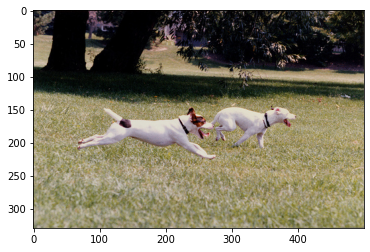

In [7]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Extrae las características de la imagen
def extract_features(filename, model):
    try:
        image = Image.open(filename)
    except:
        print("ERROR: Couldn't open image! Make sure the image path and extension is correct")
    image = image.resize((299,299))
    image = np.array(image)
    # si la imagen tiene 4 canales la convertimos en una de 3
    if image.shape[2] == 4: 
        image = image[..., :3]
    image = np.expand_dims(image, axis=0)
    image = image/127.5
    image = image - 1.0
    feature = model.predict(image)
    return feature

# Obtiene la palabra correspondiente al entero predicho
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

# Genera una descripción de una imagen a partir de un modelo entrenado
def generate_caption(model, tokenizer, photo, max_length):
    in_text = 'start'
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        pred = model.predict([photo,sequence], verbose=0)
        pred = np.argmax(pred)
        word = word_for_id(pred, tokenizer)
        if word is None:
            break
        in_text += ' ' + word
        if word == 'end':
            break
    return in_text
#path = 'Flicker8k_Dataset/111537222_07e56d5a30.jpg'

# Tomamos una imagen aleatoria para la predicción
f = open("Flickr8k_text/Flickr_8k.testImages.txt", "r")
content = f.read()
content_list = content.split("\n")
f.close()

#np.random.seed(19)
idx = np.random.randint(0,len(content_list)-1,1)[0]

# Algunas imágenes:
# perro --> 468310111_d9396abcbd.jpg 3610683688_bbe6d725ed.jpg
# montañero --> 111537222_07e56d5a30.jpg 466956209_2ffcea3941.jpg
# motorista --> 

img_name = content_list[idx]
# img_name = '3610683688_bbe6d725ed.jpg'
img_path = 'Flickr8k_Dataset/'+img_name

print('Imagen', img_name)
print('---------------------------------')
max_length = 32
tokenizer = load(open("tokenizer.p","rb"))
model = load_model('models/model_9.h5')

# Extraemos las características de la imagen de prueba con Xception de nuevo
xception_model = Xception(include_top=False, pooling="avg")
photo = extract_features(img_path, xception_model)
img = Image.open(img_path)
description = generate_caption(model, tokenizer, photo, max_length)
print("\n\n")
plt.imshow(img)

# Removing delimitators start and end from the sentence
clean_description = description.split(' ', 1)[1]
clean_description = clean_description.rsplit(' ', 1)[0]
print(clean_description)

## 10. Cálculo de BLEU

Para finalizar, me ha parecido interesante añadir al tutorial el cálculo de la métrica BLEU para medir de alguna manera la calidad de las descripciones generadas, así como ver el funcionaimento de la librería nltk para procesmiento del lenguaje natural.

In [8]:
import nltk

#Obtenemos las 5 descripciones dadas por los expertos a la imagen
test_img = [img_name]
test_descriptions = load_clean_descriptions("descriptions.txt", test_img)


hypothesis = description.split()

references = []

print('Descripciones originales:')
for i in test_descriptions[img_name]:
    print(i)
    references.append(i.split()[1:-1])

#print(references)

print('\nDescripción del modelo:')
print(clean_description)

BLEUscore2 = nltk.translate.bleu_score.sentence_bleu(references, hypothesis, weights = (0.5, 0.5))
print('\nBLEU-2:',BLEUscore2)

Descripciones originales:
<start> the two white dogs are playing in field <end>
<start> two little dogs run in the field <end>
<start> two white dogs running <end>
<start> two white dogs running in the grass together <end>
<start> two white dogs run through the grass <end>

Descripción del modelo:
two dogs are playing with each other in the grass

BLEU-2: 0.46056618647183833


## 11. Conclusiones

La generación de descripciones de imágenes automáticamente no es una tarea trivial, y son muchos los métodos y técnicas que se han empleado durante los últimos años para tratar de afrontar este problema obteniendo buenos resultados. El método propuesto ha sido seleccionado por su simplicidad, ya que me permitía tratar de desarrollar un generador de *captions* que fuera fácil de entender para gente que, como yo, esté comenzando en este campo concreto.

Los resultados obtenidos me parecen relativamente satisfactorios. Si hacemos caso a los resultados obtenidos por BLEU, realmente nuestro generador obtiene puntuaciones bastante bajas. Esto parece que se debe a que nuestro generador crea descripciones relativamente simples, mientras que las descripciones dadas por los expertos al conjunto de datos son, generalmente, mucho más complejas. Esto hace que la diferencia en los gramas de la hipótesis y las referencias sea mayor empeorando resultados de BLEU, además de que las frases excesivamente cortas también penalizan el resultado de la métrica.

Otro problema que he observado del modelo, es que parece que ha sobreentrenado un poco, ya que tiende a repetir secuencias de palabras como "dog is running".

A pesar de esto, viendo las descripciones generadas para varias imágenes aleatorias, considero que el generador más o menos es capaz de intuir los elementos principales de las imágenes, y lo veo como una buena primera toma de contacto con esta rama del aprendizaje profundo.

## Bibliografía

[1] K. Xu, J. L. Ba, R. Kiros, K. Cho, A. Courville, R. Salakhutdinov, R. S. Zemel, and Y. Bengio, “Show, attend and tell: Neural image caption generation with visual attention,” in INTERNATIONAL CONFERENCE ON MACHINE LEARNING, VOL 37 (Bach, F and Blei, D, ed.), vol. 37 of Proceedings of Machine Learning Research, pp. 2048–2057, 2015. 32nd International Conference on Machine Learning, Lille, FRANCE, JUL 07-09, 2015.

[2] M. Hodosh, P. Young, and J. Hockenmaier, “Framing image description as a ranking task: Data, models and evaluation metrics,” Journal of Artificial Intelligence Research, vol. 47, pp. 853–899, 05 2013

[3] S. Gupta, “Step by Step Guide to Build Image Caption Generator using Deep Learning”
https://www.analyticsvidhya.com/blog/2021/12/step-by-step-guide-to-build-image-caption-generator-using-deep-learning/

[4] F. Chollet, “Xception: Deep learning with depthwise separable convolutions,” in 2017 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), IEEE, July 2017